In [1]:
from system import DecisionSystem, Image
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import pandas as pd
import glob
import math
import pyrealsense2 as rs

In [2]:
import joblib
import warnings
warnings.filterwarnings('ignore')
import datetime
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [3]:
intrinsics = rs.intrinsics()
intrinsics.width = 848
intrinsics.height = 480
intrinsics.fx = 424.5785827636719
intrinsics.fy = 424.5785827636719
intrinsics.ppx = 422.18994140625
intrinsics.ppy = 244.84666442871094
intrinsics.model = rs.distortion.brown_conrady

In [4]:
img_height = 240#480
img_width = 424#848
batch_size = 16
seed = 42
epochs = 50
name = 'xception'

metrics = ['mae', 'mse', 'mape', tfa.metrics.r_square.RSquare(dtype=tf.float32, name='r2')]
metrics_name = ['MAE', 'MSE', 'MAPE', 'R2']

In [5]:
features= ['area_cc', 'width_bbox', 'height_bbox', 'mayor_axis', 'minor_axis', 'eccentricity', 'perimeter', 'percent_area', 'symmetry_v']
decision_system = DecisionSystem()

In [6]:
final_data = pd.read_csv(os.path.join("..", 'data', 'final_dataset.csv'))

final_data['height'] = 0

In [7]:
final_data.head()

,Unnamed: 0,filename,id,sex,weight,height,complete,area,area_cc,mayor_axis,...,mask_method,symmetry,symmetry_v,orientation,distance,area_bb,good,augmented,train_set,train
0,2,960fd92c91f541f6b85889426c39a0fe,0261,1,27.1,0,True,105873.0,337319.807683,667.218689,...,NEW,0.846596,0.805957,96.028503,223.376364,169363.0,Selected,False,True,True
1,3,ca10f050724d47f5971c3530ef341a8d,0236,0,25.5,0,True,75486.0,322033.996723,687.007568,...,NEW,0.880709,0.826569,110.993713,296.708611,188760.0,Selected,False,True,True
2,5,46d3f67bbf684992ac945ce7c1991ae7,0238,1,25.8,0,True,84882.5,417289.034148,626.218262,...,NEW,0.911084,0.757789,93.978134,247.121428,134375.0,Selected,False,True,True
3,6,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,25.5,0,True,77987.0,336697.949964,564.312622,...,NEW,0.757031,0.843731,61.407337,223.212903,181134.0,Selected,False,True,False
4,7,9ae21f9f018d449c87e67cbf7fe488f9,0273,1,22.5,0,True,80615.0,301201.447443,640.835327,...,NEW,0.773180,0.883582,100.848724,249.098374,153670.0,Selected,False,True,False


In [8]:
for index,row in final_data.iterrows():
    file = Image(decision_system, row.filename, 1, 1, 20, 3000)
    _, mask = cv2.threshold(file.depth_image,900,255,cv2.THRESH_BINARY)
    mask = mask.astype(np.uint8)
    size_h, size_w = mask.shape
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = []
    contour_area = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area>20000 and area<200000:
            if area>contour_area:
                contour_area = area
                contour = cnt
    img = file.depth_image
    if contour_area>500:
        x,y,w,h = cv2.boundingRect(contour)

        border = 50
        v = [x-border, x+w+border,y-border, y+h+border]
        v[0] = v[0] if v[0]>=0 else 0
        v[1] = v[1] if v[1]<size_w else size_w-1
        v[2] = v[2] if v[2]>=0 else 0
        v[3] = v[3] if v[3]<size_h else size_h-1

        img = file.depth_image[v[2]:v[3], v[0]:v[1]]
        img_color = file.color_image[v[2]:v[3], v[0]:v[1]]
        mask = mask[v[2]:v[3], v[0]:v[1]]

    depth_value = cv2.mean(img, mask)[0]
    height = rs.rs2_deproject_pixel_to_point(intrinsics, [100,100], depth_value)[2] #xyz
    height = (height / 1000)-1 #normalized
    
    final_data.at[index, 'height'] = height
    
    cv2.imwrite('../data/final/'+row.filename+'.png',file.color_image)

In [9]:
train_data = final_data[final_data['train']==True]
test_data = final_data[final_data['train']==False]

In [10]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(images=img, size=(img_height, img_width))
    return img

def process_path_sex_height(x, y, s, h):
    img = tf.io.read_file(x)
    img = decode_img(img)
    return (img,s,h) , y

In [11]:
X_train = ['../data/final/'+f+'.png' for f in train_data['filename']]
y_train = train_data['weight']
s_train = train_data['sex']
h_train = train_data['height']
X_val = ['../data/final/'+f+'.png' for f in test_data['filename']]
y_val = test_data['weight']
s_val = test_data['sex']
h_val = test_data['height']

In [12]:
files_train = tf.data.Dataset.from_tensor_slices((X_train, y_train, s_train, h_train))
files_val = tf.data.Dataset.from_tensor_slices((X_val, y_val, s_val, h_val))

train_ds = files_train.map(process_path_sex_height).batch(batch_size)
val_ds = files_val.map(process_path_sex_height).batch(batch_size)

In [13]:
base_model = keras.applications.Xception(weights='imagenet', input_shape=(img_height, img_width, 3), include_top=False)
base_model.trainable = False

inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.Model(inputs=inputs, outputs=x)
inputB = keras.Input(shape=(1,))
inputC = keras.Input(shape=(1,))
combined = keras.layers.concatenate([x.output, inputB, inputC])
outputs = keras.layers.Dense(128, activation='relu')(combined)
outputs = keras.layers.Dense(1)(outputs)
model = keras.Model(inputs=[x.input, inputB, inputC], outputs=outputs)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='mae', metrics=metrics)
h = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
df_historic = pd.DataFrame(h.history)

Epoch 1/50
30/30 [==============================] - 58s 2s/step - loss: 16.5404 - mae: 16.5404 - mse: 313.6964 - mape: 74.8832 - r2: -14.3040 - val_loss: 9.4458 - val_mae: 9.4458 - val_mse: 103.0623 - val_mape: 43.7390 - val_r2: -9.1180
Epoch 2/50
30/30 [==============================] - 54s 2s/step - loss: 7.2499 - mae: 7.2499 - mse: 73.3276 - mape: 32.2692 - r2: -2.5774 - val_loss: 3.7749 - val_mae: 3.7749 - val_mse: 18.0570 - val_mape: 19.0069 - val_r2: -0.7727
Epoch 3/50
30/30 [==============================] - 55s 2s/step - loss: 4.8134 - mae: 4.8134 - mse: 34.2305 - mape: 25.7613 - r2: -0.6700 - val_loss: 3.8462 - val_mae: 3.8462 - val_mse: 21.9148 - val_mape: 20.4597 - val_r2: -1.1514
Epoch 4/50
30/30 [==============================] - 57s 2s/step - loss: 4.1546 - mae: 4.1546 - mse: 26.3472 - mape: 22.0451 - r2: -0.2854 - val_loss: 3.5689 - val_mae: 3.5689 - val_mse: 18.3164 - val_mape: 18.8048 - val_r2: -0.7982
Epoch 5/50
30/30 [==============================] - 57s 2s/step - l

30/30 [==============================] - 56s 2s/step - loss: 0.8314 - mae: 0.8314 - mse: 1.7439 - mape: 3.7943 - r2: 0.9149 - val_loss: 3.0337 - val_mae: 3.0337 - val_mse: 11.5624 - val_mape: 15.5617 - val_r2: -0.1351
Epoch 37/50
30/30 [==============================] - 57s 2s/step - loss: 0.7671 - mae: 0.7671 - mse: 1.6196 - mape: 3.4806 - r2: 0.9210 - val_loss: 3.1291 - val_mae: 3.1291 - val_mse: 12.3069 - val_mape: 16.0514 - val_r2: -0.2082
Epoch 38/50
30/30 [==============================] - 56s 2s/step - loss: 0.8566 - mae: 0.8566 - mse: 1.7248 - mape: 3.9616 - r2: 0.9159 - val_loss: 3.3191 - val_mae: 3.3191 - val_mse: 13.8920 - val_mape: 17.0609 - val_r2: -0.3638
Epoch 39/50
30/30 [==============================] - 56s 2s/step - loss: 0.8851 - mae: 0.8851 - mse: 1.7745 - mape: 4.1169 - r2: 0.9134 - val_loss: 3.2148 - val_mae: 3.2148 - val_mse: 13.0087 - val_mape: 16.5202 - val_r2: -0.2771
Epoch 40/50
30/30 [==============================] - 57s 2s/step - loss: 0.7417 - mae: 0.741

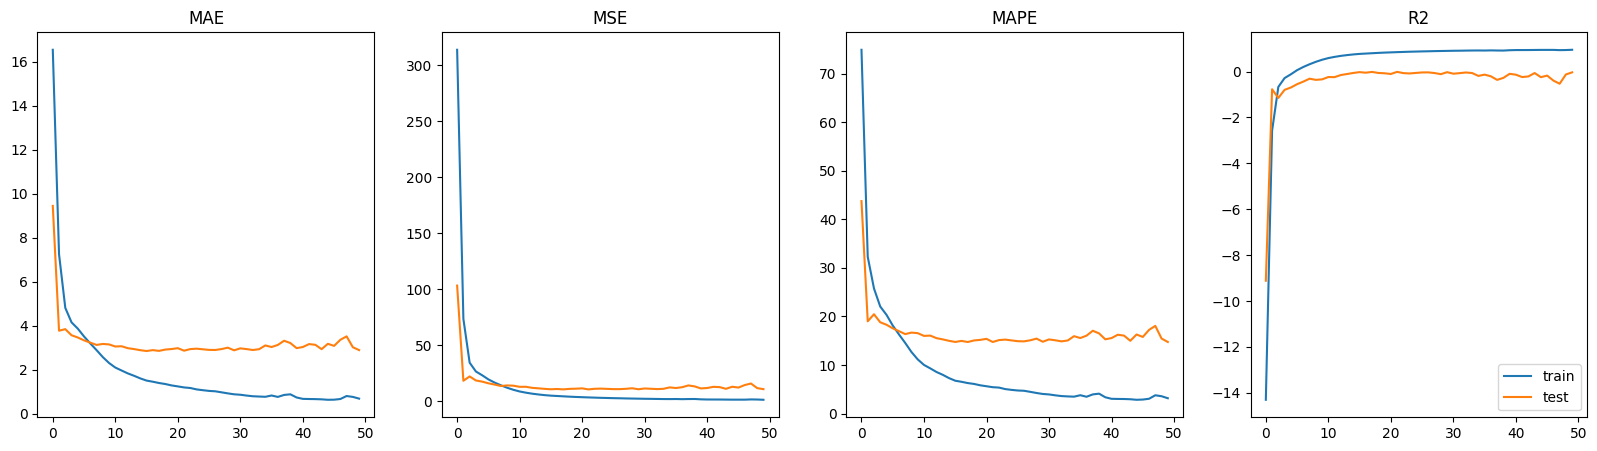

In [14]:
fig, ax = plt.subplots(1, len(metrics), figsize=(20, 5))

info={}
for metric, i in zip(metrics_name, range(len(metrics))):
    ax[i].plot(df_historic[metric.lower()], label='train')
    ax[i].plot(df_historic['val_'+metric.lower()], label='test')
    ax[i].set_title(metric)

plt.legend()
plt.show()

In [15]:
df_historic.head(25)

,loss,mae,mse,mape,r2,val_loss,val_mae,val_mse,val_mape,val_r2
0,16.540392,16.540392,313.696381,74.883171,-14.304030,9.445827,9.445827,103.062325,43.738995,-9.117958
1,7.249915,7.249915,73.327629,32.269180,-2.577371,3.774907,3.774907,18.057047,19.006886,-0.772718
2,4.813380,4.813380,34.230545,25.761314,-0.669976,3.846240,3.846240,21.914766,20.459660,-1.151443
3,4.154644,4.154644,26.347160,22.045090,-0.285376,3.568918,3.568918,18.316414,18.804819,-0.798181
4,3.869299,3.869299,22.984447,20.344847,-0.121322,3.467089,3.467089,17.289118,18.298861,-0.697328
5,3.512774,3.512774,19.274078,18.142118,0.059692,3.336896,3.336896,15.800573,17.565603,-0.551193
6,3.196709,3.196709,16.417971,16.300234,0.199031,3.232233,3.232233,14.657805,16.974459,-0.439004
7,2.893280,2.893280,13.983428,14.548120,0.317803,3.129504,3.129504,13.366076,16.375347,-0.312190
8,2.576795,2.576795,11.814139,12.677405,0.423634,3.173723,3.173723,13.881922,16.682505,-0.362833
9,2.307481,2.307481,9.983371,11.161424,0.512950,3.152017,3.152017,13.665754,16.566259,-0.341611
